### STEP 5: SPLIT_ADOPTION

- Split the data from given conditions adOption == 1 and == 0
- Check for corrolations, what positively and negatively effects the coin spending
- Run predictions and adjust adOption delivery percentage based on preditions

Import the arsenal

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

Load the battery

In [3]:
df = pd.read_csv('data_the_babe/df_1m_comp.csv')

Split the data

In [4]:
df_1 = df[df['adOption']==1]
df_0 = df[df['adOption']==0]

In [5]:
print(df_1.shape)
print(df_0.shape)

(202202, 44)
(761390, 44)


Find probability of randomized adOption.

In [6]:
df_1.shape[0] / df.shape[0]

0.2098419247980473

Historical probability of adOption is 21%.

Find probability of coin spending given that adOption == 1

0.03293735967003294


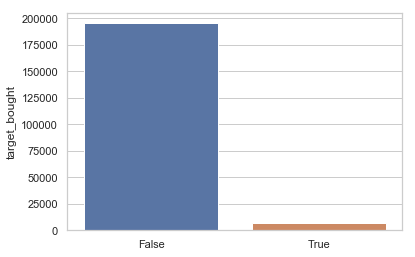

In [7]:
counts = df_1['target_bought'].value_counts()
sns.barplot(counts.index, counts);
print(df_1.target_bought.sum() / len(df_1.target_bought))

Find probability of coin spending given that adOption == 0

0.0778562891553606


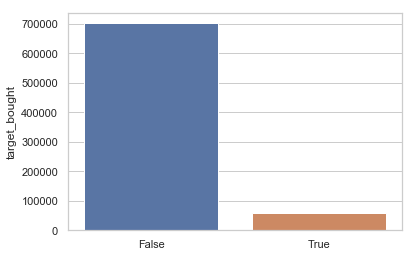

In [8]:
counts = df_0['target_bought'].value_counts()
sns.barplot(counts.index, counts);
print(df_0.target_bought.sum() / len(df_0.target_bought))

- Given adOption = 1, probability of spending coin ==> 3.3%
- Given adOption = 0, probability of spending coin ==> 7.8%

Also given these coin spending ratios, the data is significantly unbalanced. Unbalanced data may make our model predict that every player will refuse spending coins due to the high ratio of Falses in training set.

Will use SMOTE which oversamples the data in order to balance True and False datasets.

0.3218069059653218


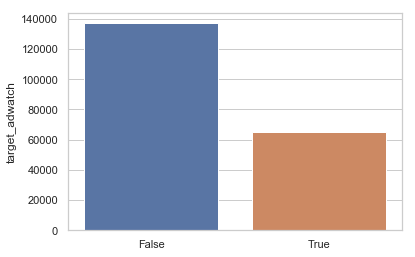

In [9]:
counts = df_1['target_adwatch'].value_counts()
sns.barplot(counts.index, counts);
print(df_1.target_adwatch.sum() / len(df_1.target_adwatch))

0


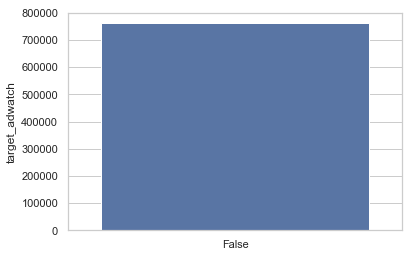

In [10]:
counts = df_0['target_adwatch'].value_counts()
sns.barplot(counts.index, counts);
print(df_0.target_adwatch.sum())

- Given adOption = 1 , probability of watching the add ==> 32%
- Given adOption = 0, probability of watching the add ==> 0

(because players don't even see the ad_option when adOption == 1)

In [11]:
print(df_1.target_adwatch.sum() / len(df_1.target_adwatch))
print(df_0.target_adwatch.sum())

0.3218069059653218
0


Lets see of the coin spending patterns between adOption = 1 and adOption = 0 are meaningful.

Following function is an ***AB test***, and if it returns True, it means the difference is not by pure luck and we can be 95% confident with such argument.

I normally use the following code for conversion rates. In our given real world senario clicks are offer counts and views are number of coin spending occasions.

In [12]:
from numpy.random import beta as beta_dist
import numpy as np

def meaningful_diff(clicks_A, views_A, clicks_B, views_B):
    '''
    INPUT: INT, INT, INT, INT
    OUTPUT: FLOAT

    Calculate and return an estimated probability that SiteA performs better
    (has a higher click-through rate) than SiteB.

    Hint: Use Bayesian A/B Testing (multi-armed-bandit repo).
    '''
    num_samples = 1000
    A_samples = beta_dist(1 + clicks_A, 1 + views_A - clicks_A, num_samples)
    B_samples = beta_dist(1 + clicks_B, 1 + views_B - clicks_B, num_samples)
    
    result = np.mean(A_samples < B_samples)
    return bool(result)

In [13]:
A_views = len(df_1.target_bought)
A_bought = df_1.target_bought.sum()
B_views  = len(df_0.target_bought)
B_bought = df_0.target_bought.sum()

In [14]:
meaningful_diff(A_bought, A_views, B_bought, B_views)

True

Lets See The corrolations in our dataset. To do that I will use a half seaborn heatmap. Its personal, half heatmaps are easier to interpret for me.

In [15]:
def heatmap(df):

    from string import ascii_letters
    import numpy as np
    import pandas as pd
    import seaborn as sns
    import matplotlib.pyplot as plt

    sns.set(style="white")


    # Compute the correlation matrix
    corr = df.corr()

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [16]:
df = df.drop(['Unnamed: 0', 'Unnamed: 0.1','target_both','Unknown'],axis=1)

In [17]:
# df_2 = df.drop(['target_adwatch','w0','w10','w20','w30','w40','w60'],axis=1)

In [18]:
# df_2 = df_2.drop(['w50','de','en','es','fr','it','pt-BR','ru','tr','zh-CN'],axis = 1)

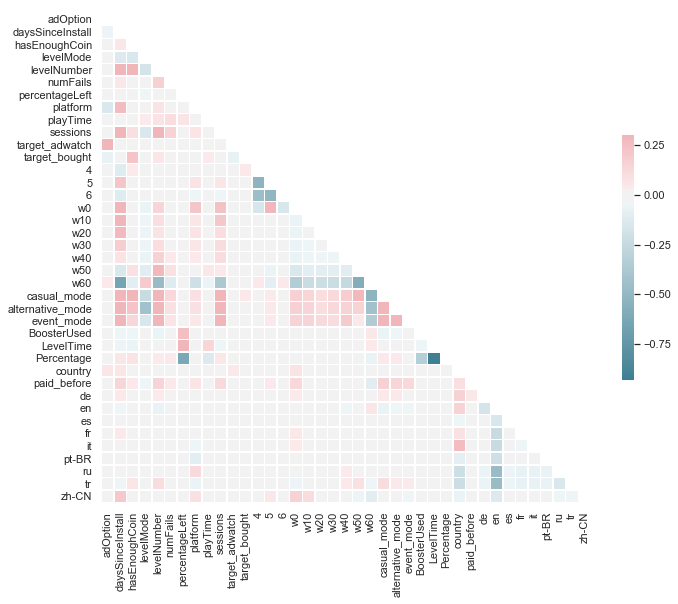

In [19]:
heatmap(df)

In accordance to heatmap, target_bought(coin_spending) is 
positively corrolated with: causal_mode , 4, hasEnoughCoin, playTime, level number
negatively corrolated with: adOption (as we already knew)


- causal_mode --> players which prefer causal mode are more likely to use coins compared to alternative modes(this is probablydue to that the causal mode is more competative in world ranking).

- 4 --> The number of coins to continue can be 4,5 or 6. Since 4 is the least number of coins asked in an offer, players are more likely to accept the coin spending offer. In other words players are sensitive about the amount of coins asked.

- hasEnoughCoin  --> if a player has enough coin in their bank they are more likely to spend those at the moment of offer(I am not surprised at all).

- playTime --> more time a player spends on a particular level, more likely they are to commit coins because such behavior is a sign of struggle. More frustrated they become, more leverage they have to spend money. 

- level number --> higher level numbers lead to increased coin spending. Again makes sense due to the fact that 
(1)upper levels are more challenging
(2)Players which achive upper levels are likely to be more committed to the game. 

and as already target bought is  negatively corrolated with
- adOption  --> not surprised because if adOption is provided players are more likely to watch adds in order to save coins

***Modelling***

I always check what I have within the features.

In [20]:
df.columns

Index(['adOption', 'daysSinceInstall', 'hasEnoughCoin', 'levelMode',
       'levelNumber', 'numFails', 'percentageLeft', 'platform', 'playTime',
       'playerId', 'sessions', 'target_adwatch', 'target_bought', '4', '5',
       '6', 'w0', 'w10', 'w20', 'w30', 'w40', 'w50', 'w60', 'casual_mode',
       'alternative_mode', 'event_mode', 'BoosterUsed', 'LevelTime',
       'Percentage', 'country', 'paid_before', 'de', 'en', 'es', 'fr', 'it',
       'pt-BR', 'ru', 'tr', 'zh-CN'],
      dtype='object')

In [21]:
y = df.target_bought
X = df.drop(['target_bought','playerId'],axis=1)

In [22]:
X.columns

Index(['adOption', 'daysSinceInstall', 'hasEnoughCoin', 'levelMode',
       'levelNumber', 'numFails', 'percentageLeft', 'platform', 'playTime',
       'sessions', 'target_adwatch', '4', '5', '6', 'w0', 'w10', 'w20', 'w30',
       'w40', 'w50', 'w60', 'casual_mode', 'alternative_mode', 'event_mode',
       'BoosterUsed', 'LevelTime', 'Percentage', 'country', 'paid_before',
       'de', 'en', 'es', 'fr', 'it', 'pt-BR', 'ru', 'tr', 'zh-CN'],
      dtype='object')

In [23]:
y_2 = X.drop(['target_adwatch'],axis = 1)

***Train Test Split***

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=45)

***SMOTE***

In [25]:
from imblearn.over_sampling import SMOTE

os = SMOTE(random_state=0)

columns = X_train.columns
os_data_X,os_data_y = os.fit_sample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['y'])

# we can Check the numbers of our data
print("length of oversampled data is ",len(os_data_X))
print("Number of no subscription in oversampled data",len(os_data_y[os_data_y['y']==0]))
print("Number of subscription",len(os_data_y[os_data_y['y']==1]))
print("Proportion of no subscription data in oversampled data is ",len(os_data_y[os_data_y['y']==0])/len(os_data_X))
print("Proportion of subscription data in oversampled data is ",len(os_data_y[os_data_y['y']==1])/len(os_data_X))

length of oversampled data is  1257128
Number of no subscription in oversampled data 628564
Number of subscription 628564
Proportion of no subscription data in oversampled data is  0.5
Proportion of subscription data in oversampled data is  0.5


***Logistic Regression***

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

logreg = LogisticRegression()
logreg.fit(os_data_X, os_data_y)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [27]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))
y_prob = logreg.predict_proba(X_test)[:, 1]

Accuracy of logistic regression classifier on test set: 0.58


In [28]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.99      0.55      0.71    269089
        True       0.14      0.94      0.24     19989

   micro avg       0.58      0.58      0.58    289078
   macro avg       0.56      0.75      0.47    289078
weighted avg       0.93      0.58      0.68    289078



Looks as if the logistic model performs worse compared to initial ones eh? Just by checking the accuracy score you are most certainly right. Yet as a reminder, the former models scored high on accuracy simply by setting all the prediction outputs to Negative(false). On the other hand this one actually did some True predictions which led to a more balanced scores for positive and negative predictions. 

***GB Classifier***

In [43]:
from sklearn.ensemble import GradientBoostingClassifier

In [44]:
gb = GradientBoostingClassifier(learning_rate = 0.01, n_estimators = 1000)
gb.fit(os_data_X,os_data_y)

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=1000,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [45]:
gb.score(X_test, y_test)

0.9289465127059133

In [46]:
y_pred_gb = gb.predict(X_test)

In [47]:
y_pred_gb = gb.predict(X_test)
print('Accuracy of GB classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))
y_prob_gb = gb.predict_proba(X_test)[:, 1]

Accuracy of GB classifier on test set: 0.58


In [48]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_gb))

              precision    recall  f1-score   support

       False       0.93      1.00      0.96    269089
        True       0.32      0.02      0.05     19989

   micro avg       0.93      0.93      0.93    289078
   macro avg       0.63      0.51      0.50    289078
weighted avg       0.89      0.93      0.90    289078



Although accuracy scores of both models are same, only 1% recall score is concerning me with the gradient boost classifier.

Thereby I will go with the logistic regression model.

### ROC Curve and AUC

In [29]:
from sklearn.metrics import auc, roc_curve
from src.funky import plot_roc

The ROC Curve shows the rate of the model false positive by true positive predictions over a range of threshold values, from 0 to 1. Here, it is used to quantify the predicitve power of this model using the characteristic statistic, AUC (Area Under the Curve).

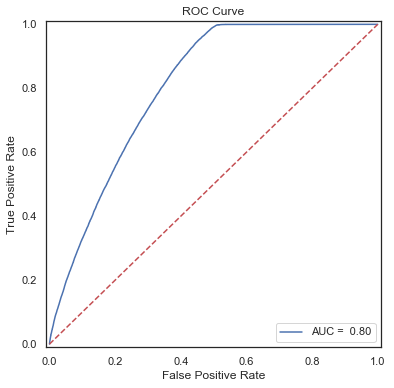

In [30]:
# Compute ROC and AUC
fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_prob)
auc_score = auc(fpr, tpr)

plot_roc(fpr, tpr, auc_score)

This ROC and AUC show a rather even ability for the model to differntiate the two predicted classes with 80% probability.

***Profit Curve***

In [31]:
from sklearn.metrics import confusion_matrix

1. Define a cost benefit matrix Multiply it with confusion matrix

2. Optimize model treshold Find the treshold that maximizes profit

3. Treshold for probability of positive.

- Cost Benefit Matrix

Info:
Statistical Average for Mobile Gaming is: adCPM $ 5 ( One adwatch generates $0.005)

Assumption: Spending coins generates 80 times more revenue compared to adwatch.

Cost benefit matrix baseline: Do nothing if predict positive(the player will spend coins)

- tp = 0 (do nothing)
- fn = P(addoption == 0) * ((adwatch_revenue * P(adoption==1))-Missed Revenue From Coins *P(coin |!adoption) - P(coin|adoption))
- tn = P(addoption == 0) * P(adwatch | adoption) * adwatch_revenue
- fp = 0 (do nothing)

tp = model predicted that the player will spend coin and player spent
tp reaction --> do not provide adOption, probability of a player to spend coin is higher

fn = model predicted that the player will not spend coin, but actually the player was going to
fn reaction --> provide ads(decreases chances of spending coin)

tn = model predicted that the player will not spend coin, and player did not
tn reaction --> provide adOption(so company still generates some money)

fp = the model predicted that the player is going tp use coins, yet the player did not.
fp reaction --> do not provide adOption(missed )


Setting the baseline model as do nothing.

In [32]:
tp = 0
fn = 0.79 * ((0.005 * 0.32)- 0.4 * (0.078-0.033))
tn = 0.79 * 0.32 * 0.005
fp = 0

In [33]:
#                       tp fn      fp tn
benefit_mat = np.array([[tp, fn], [fp, tn]])
benefit_mat

array([[ 0.      , -0.012956],
       [ 0.      ,  0.001264]])

Create the linnear space from 0 to 100.

In [34]:
treshholds = np.linspace(0,1,100)

Find expected profit for each and every treshold.

In [35]:
expected_profit = []
for t in treshholds:
    predictions = (y_prob > t).astype(int)
    tn, fp, fn, tp = confusion_matrix( y_test, predictions).ravel()
    conf_mat = np.array([[tp, fn], [fp, tn]])
    expected_profit.append((benefit_mat * conf_mat).sum())


Get the index number which returns the highest profit from expected_profit list.

In [36]:
maximum_expected_profit_index = np.argsort(np.array(expected_profit))[-1]

In [37]:
maximum_expected_profit_index

57

In [38]:
expected_profit[maximum_expected_profit_index]

174.62191600000006

In [39]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
conf_mat = np.array([[tp, fn], [fp, tn]])
conf_mat

array([[ 18857,   1132],
       [120359, 148730]])

Lets see how the expected profit changes over increasing tresholds.

Treshold that gives the highest expected profit:0.5757575757575758


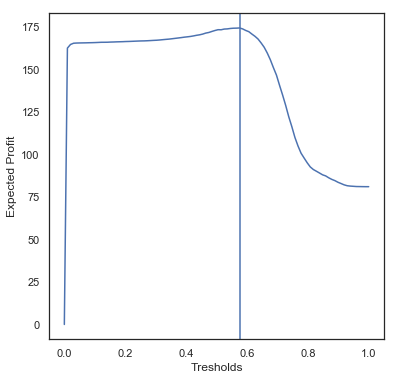

In [40]:
plt.figure(figsize=(6,6))
plt.plot(treshholds, expected_profit, label='XGBoost Classifier')
plt.xlabel('Tresholds')
plt.ylabel('Expected Profit')
plt.axvline(treshholds[maximum_expected_profit_index])
print(f'Treshold that gives the highest expected profit:{treshholds[maximum_expected_profit_index]}')

Lets see what percentage of  people are likely use coins in accordance to the model.

In [41]:
(y_prob > 0.57).mean()

0.42097980475857727

Model assigns a score (even though it could be called a probability, let's call it a score) that ranks users from "most likely to spend coins" to "least likely to spend coins". By varying the threshold, the model says "let's classify every user with a score above the threshold as a 'spender' and everyone below it as a 'non-spender", then profit is calculated for each treshold. By finding the threshold T (above which lie X% of users) with the highest profit, you then say "by classifying the top X% highest scores as 'spenders', I get the maximum profit"

The following will give us the optimum adwatch delivery ratio.

In [42]:
1 - (y_prob > 0.57).mean()

0.5790201952414227

Consequently in accordance to model, the users which have a probability of spending coins less than 57% which also corresponds to 57% of the dataset should receive an adoffer. A dramatic increase from historical 21%.

Now we know that the adoffer rate should increase in order to generate more revenue and we have an idea about which features positively corrolated with coin spending. Additionally we can find out feature importances to increase confidence in critical factors which has a effect on coin spending patterns.

***Feature Importances***

Random forest

In [219]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 500 decision trees
rf = RandomForestRegressor(n_estimators = 500, random_state = 42)
# Train the model on training data
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

Importances by ratio.

In [221]:
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(X.columns, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: playTime             Importance: 0.16
Variable: sessions             Importance: 0.11
Variable: daysSinceInstall     Importance: 0.09
Variable: levelNumber          Importance: 0.09
Variable: casual_mode          Importance: 0.09
Variable: numFails             Importance: 0.08
Variable: percentageLeft       Importance: 0.07
Variable: alternative_mode     Importance: 0.07
Variable: hasEnoughCoin        Importance: 0.05
Variable: platform             Importance: 0.02
Variable: adOption             Importance: 0.01
Variable: 4                    Importance: 0.01
Variable: 5                    Importance: 0.01
Variable: 6                    Importance: 0.01
Variable: w50                  Importance: 0.01
Variable: event_mode           Importance: 0.01
Variable: country              Importance: 0.01
Variable: en                   Importance: 0.01
Variable: fr                   Importance: 0.01
Variable: it                   Importance: 0.01
Variable: pt-BR                Importanc

Visualize feature importances because why not.

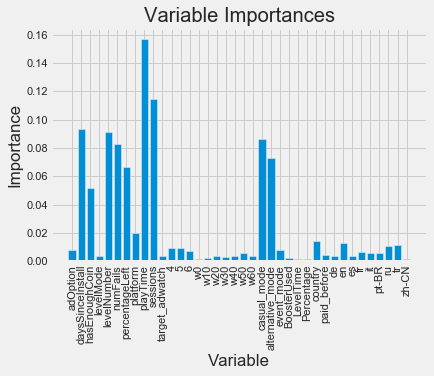

In [224]:
feature_list = X.columns
# Import matplotlib for plotting and use magic command for Jupyter Notebooks
import matplotlib.pyplot as plt
%matplotlib inline
# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

**We learned a couple of things from this project**

**Project goal related recomendations:**

We have found a more effective way compared to simply blending adOption to the offer by 21% random chance. 

Instead, logistic model findings states that increasing the adOffer ratio to 42% based on the 57.7% treshold and following conditions maximizes the profit.

if;
- playtime of the player is high in terms of seconds for the particular level that player died
- the player leveled up through game seasons
- the number of days since the player installed the game is significant
- the game mode is set to causal mode
- the percentage left towards the end of the level is low
- player failed for a couple of times in a particular level before offer
- the player already have enough coins to proceed in his bank(more than 4,5 or 6 coins)

***Data Science Related Reminders:***

Datasets with unbalanced binary targets are tricky because the model learns more from the dominant label which usually leads to overfit. Consequently model predicts as if there is only the dominant option which means the signal for the weaker option is set to 0.

We observed this within our dataset in which the ratio of players which do not pay is significantly higher compared to players that accept the coin option. 

SMOTE is a way to train a more balanced dataset for the prediction models. On the other hand it may not be effective for each and every dataset. In our case SMOTE actually worked fine which generated signal for positive predictions. But the question is, did it really do a good job? 

I don't think so due to the high number of false positive predictions. Regardless of that, it increased the signal for positive predictions which gave us a business solution.